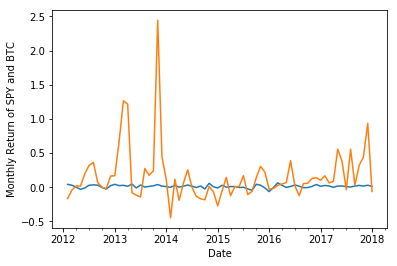

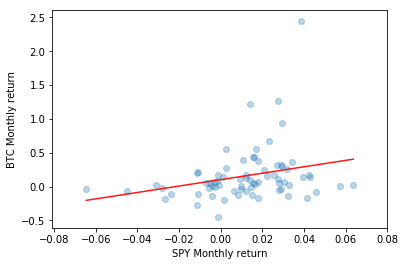

alpha = 0.10251609463968894

rvalue = 0.2664551722048453

slope = 4.741705538062105

std_err = 2.0500745128897453



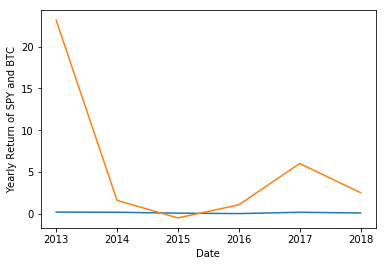

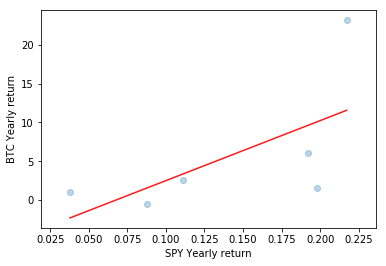

alpha = -5.217390035982163

rvalue = 0.6308808918344961

slope = 77.26754177609178

std_err = 47.513181555327684



In [243]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as pl
from pandas_datareader.data import DataReader
from statsmodels import regression


def linear_regression(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1]
    return model.params[0], model.params[1]


#Monthly
BTC = DataReader('BTC-USD',  'yahoo', '2012-01-01', '2018-01-01')
SPY = DataReader('SPY',  'yahoo', '2012-01-01', '2018-01-01')
BTC_return_monthly = BTC.groupby(pd.Grouper(freq='MS'))['Adj Close'].mean()
BTC_return_monthly = BTC_return_monthly.pct_change()[1:]
SPY_return_monthly = SPY.groupby(pd.Grouper(freq='MS'))['Adj Close'].mean()
SPY_return_monthly = SPY_return_monthly.pct_change()[1:]

SPY_return_monthly.plot()
BTC_return_monthly.plot()
pl.ylabel("Monthly Return of SPY and BTC")
pl.show()


X = SPY_return_monthly.values
Y = BTC_return_monthly.values
alpha, beta = linear_regression(X,Y)
X2 = np.linspace(X.min(), X.max(), 100)
Y_tilda = X2* beta + alpha
pl.scatter(X,Y, alpha = 0.3)
pl.xlabel("SPY Monthly return")
pl.ylabel("BTC Monthly return")
pl.plot(X2, Y_tilda, 'r', alpha = 0.9)
pl.show()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)
print("alpha = " + str(alpha) + "\n")
print("rvalue = " +  str(r_value) + "\n")
print("slope = " +   str(slope) + "\n")
print("std_err = " +  str(std_err) + "\n")


BTC = DataReader('BTC-USD',  'yahoo', '2012-01-01', '2018-01-01')
SPY = DataReader('SPY',  'yahoo', '2012-01-01', '2018-01-01')
BTC_return_yearly = BTC.groupby(pd.Grouper(freq='YS'))['Adj Close'].mean()
BTC_return_yearly = BTC_return_yearly.pct_change()[1:]
SPY_return_yearly = SPY.groupby(pd.Grouper(freq='YS'))['Adj Close'].mean()
SPY_return_yearly = SPY_return_yearly.pct_change()[1:]


SPY_return_yearly.plot()
BTC_return_yearly.plot()
pl.ylabel("Yearly Return of SPY and BTC")
pl.show()


X = SPY_return_yearly.values
Y = BTC_return_yearly.values

alpha, beta = linear_regression(X,Y)
X2 = np.linspace(X.min(), X.max(), 100)
Y_tilda = X2* beta + alpha
pl.scatter(X,Y, alpha = 0.3)
pl.xlabel("SPY Yearly return")
pl.ylabel("BTC Yearly return")
pl.plot(X2, Y_tilda, 'r', alpha = 0.9)
pl.show()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)


print("alpha = " + str(alpha) + "\n")
print("rvalue = " +  str(r_value) + "\n")
print("slope = " +   str(slope) + "\n")
print("std_err = " +  str(std_err) + "\n")
